_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat GPT, used for autompletion and debugging.*

# Coding Lab 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io
import os

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline

curr_dir = os.getcwd()
if not curr_dir.endswith("notebooks"):
    curr_dir = os.chdir(curr_dir + "/notebooks")
plt.style.use("../matplotlib_style.txt")

Last updated: 2025-05-25 12:25:36Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.22.2

sklearn: 1.4.2

numpy     : 1.26.4
scipy     : 1.12.0
matplotlib: 3.8.3

Watermark: 2.5.0



# Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise (binary) with a stimulus intesity of 5 (peak to peak). R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end derive mathematically and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Make sure you include intermediate steps of the mathematical derivation in your answer, and you give as final form the maximally simplified expression, substituting the corresponding variables.

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate. Plot the true and the estimated receptive field. 

*Grading: 2 pts (calculations) + 4 pts (generation) + 4 pts (implementation)*


### Calculations (2 pts)
_You can add your calculations in_ $\LaTeX$ _here_. 

$L(\omega) = \ldots$

$\frac{dL(\omega)}{d\omega} = \ldots$

$$
L(w)
= \log \prod_{t=1}^{n_T} \frac{r_t^{\,c_t}}{c_t!} e^{-r_t}
= \sum_{t=1}^{n_T} \bigl[c_t \log r_t - r_t - \log(c_t!)\bigr].
$$

$$
\text{where}\quad
r_t = \exp\bigl(w^\top s_t\bigr)\,\Delta t\,R.
$$

Thus
$$
\begin{aligned}
L(w)
&= \sum_{t=1}^{n_T} \Bigl[\,c_t\bigl(w^\top s_t + \log(\Delta t\,R)\bigr)
- \exp(w^\top s_t)\,\Delta t\,R
- \log(c_t!)\Bigr],\\
-\,L(w)
&= \sum_{t=1}^{n_T} \Bigl[\exp(w^\top s_t)\,\Delta t\,R
- c_t\,(w^\top s_t)\Bigr]
+ \underbrace{\sum_{t=1}^{n_T}\bigl[-\,c_t\log(\Delta t\,R) + \log(c_t!)\bigr]}_{\text{constant in }w}.
\end{aligned}
$$

Discarding the constant term, our objective is
$$
\mathcal{J}(w)
= \sum_{t=1}^{n_T} \Bigl[\exp(w^\top s_t)\,\Delta t\,R \;-\; c_t\,(w^\top s_t)\Bigr].
$$

Its gradient is
$$
\nabla_w \mathcal{J}(w)
= \sum_{t=1}^{n_T} \Bigl[\exp(w^\top s_t)\,\Delta t\,R - c_t\Bigr]\,s_t
= \sum_{t=1}^{n_T} (r_t - c_t)\,s_t.
$$

### Generate data (2 pts)

Text(0.5, 1.0, 'Gaussian RF')

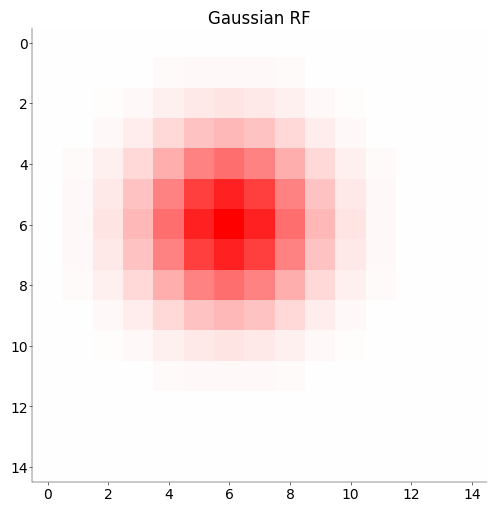

In [2]:
def gen_gauss_rf(D: int, width: float, center: tuple = (0, 0)) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """

    sz = (D - 1) / 2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [3]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, s_i: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    s_i: float
        stimulus intensity peak to peak

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (1 pt)
    # ------------------------------------------------
    D = w.shape[0]
    # Stimulus: Gaussian IID
    s = rng.normal(loc=0.0, scale=s_i, size=(D, nT))
    # Linear filter output
    lin = w @ s  # shape (nT,)
    r = np.exp(lin) * dt * R  # shape (nT,)
    # Generate Poisson spikes
    c = rng.poisson(lam=r)
    return c, r, s

In [4]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
s_i = 5  # stimulus intensity

w = gen_gauss_rf(D, 7, (1, 1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, s_i)

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

C:\Users\Julius\AppData\Local\Temp\ipykernel_18288\851930843.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


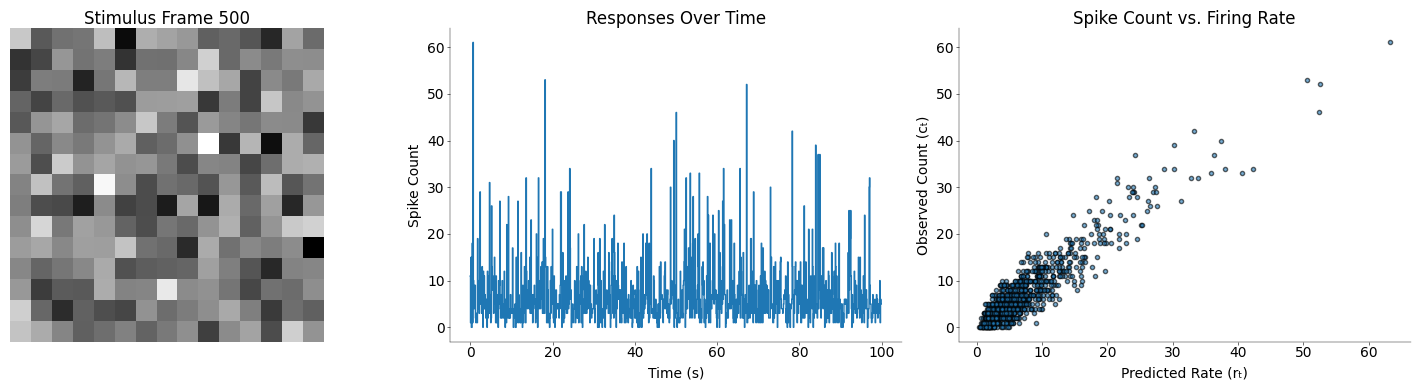

In [5]:
mosaic = mosaic = [["stim", "responses", "count/rate"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (1 pt)
# -----------------------------------------------------------------------------------------------------------

# Plot the stimulus for one frame
t0 = nT // 2
D = s.shape[0]
side = int(np.sqrt(D))
stim_frame = s[:, t0].reshape(side, side)

ax["stim"].imshow(stim_frame, cmap="gray", aspect="equal")
ax["stim"].set_title(f"Stimulus Frame {t0}")
ax["stim"].axis("off")

# Plot the cell's responses (spike counts) over time
time = np.arange(nT) * dt
ax["responses"].plot(time, c, drawstyle="steps-mid")
ax["responses"].set_xlabel("Time (s)")
ax["responses"].set_ylabel("Spike Count")
ax["responses"].set_title("Responses Over Time")

# Plot spike count vs. predicted firing rate
ax["count/rate"].scatter(r, c, alpha=0.6, edgecolor="k")
ax["count/rate"].set_xlabel("Predicted Rate (rₜ)")
ax["count/rate"].set_ylabel("Observed Count (cₜ)")
ax["count/rate"].set_title("Spike Count vs. Firing Rate")

plt.tight_layout()
plt.show()

### Implementation (3 pts)

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(1 pt)_

In [6]:
def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    lin = w @ s
    r = np.exp(lin) * dt * R
    # Negative log-likelihood (omit constant terms)
    return np.sum(r) - c.dot(lin)


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w

    """

    # --------------------------------------------------------------
    # Implement the gradient with respect to the receptive field `w`
    # --------------------------------------------------------------
    lin = w @ s
    r = np.exp(lin) * dt * R

    return s @ (r - c)

The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [7]:
# Check gradient
from scipy.optimize import minimize
from scipy.optimize import check_grad

# Initial guess
w0 = np.zeros_like(w)

# Perform the gradient check
error = check_grad(negloglike_lnp, deriv_negloglike_lnp, w0, c, s, dt, R)
print(f"Gradient check error: {error:.2e}")

Gradient check error: 1.43e-02


Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [8]:
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------
w0 = np.zeros_like(w)  # initial guess
res = minimize(
    fun=negloglike_lnp,
    x0=w0,
    args=(c, s, dt, R),
    jac=deriv_negloglike_lnp,
    method="BFGS",
    options={"disp": True},
)
w_est = res.x.reshape((int(np.sqrt(w.size)),) * 2)

Optimization terminated successfully.
         Current function value: 2114.826542
         Iterations: 246
         Function evaluations: 423
         Gradient evaluations: 423


Plot the true and the estimated receptive field.

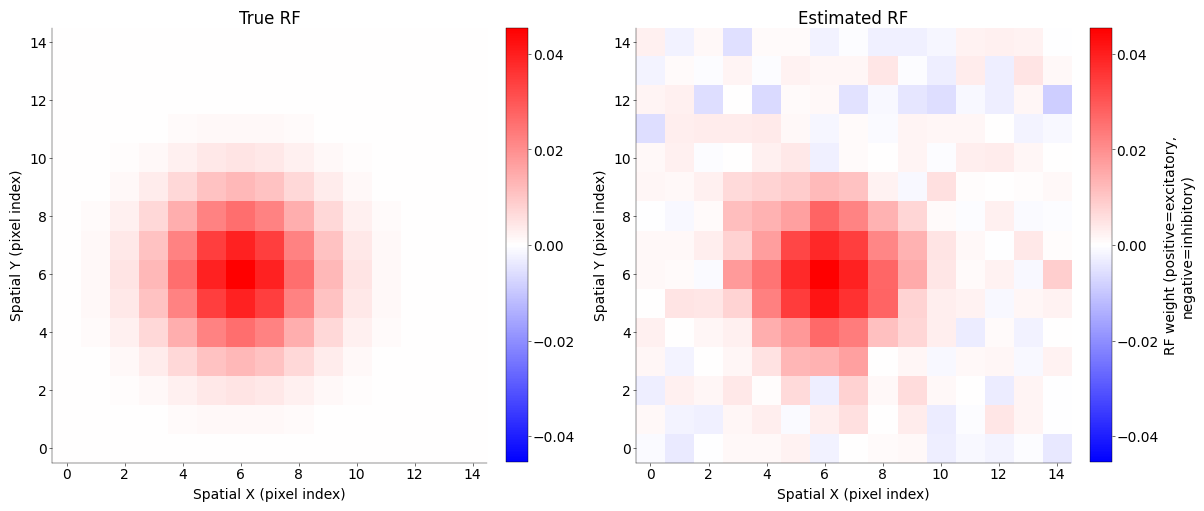

In [9]:
# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (1 pt)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5))

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.
vlim = np.max(np.abs(w))

# True RF
im0 = ax["True"].imshow(
    w.reshape(w_est.shape), cmap="bwr", vmin=-vlim, vmax=vlim, origin="lower"
)
ax["True"].set_title("True RF")
ax["True"].set_xlabel("Spatial X (pixel index)")
ax["True"].set_ylabel("Spatial Y (pixel index)")
cbar0 = fig.colorbar(im0, ax=ax["True"], fraction=0.046, pad=0.04)

# Estimated RF
im1 = ax["Estimated"].imshow(w_est, cmap="bwr", vmin=-vlim, vmax=vlim, origin="lower")
ax["Estimated"].set_title("Estimated RF")
ax["Estimated"].set_xlabel("Spatial X (pixel index)")
ax["Estimated"].set_ylabel("Spatial Y (pixel index)")
cbar1 = fig.colorbar(im1, ax=ax["Estimated"], fraction=0.046, pad=0.04)
cbar1.set_label("RF weight (positive=excitatory,\nnegative=inhibitory)")

plt.show()

# Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 3.5 pts*


(20, 15, 1500)


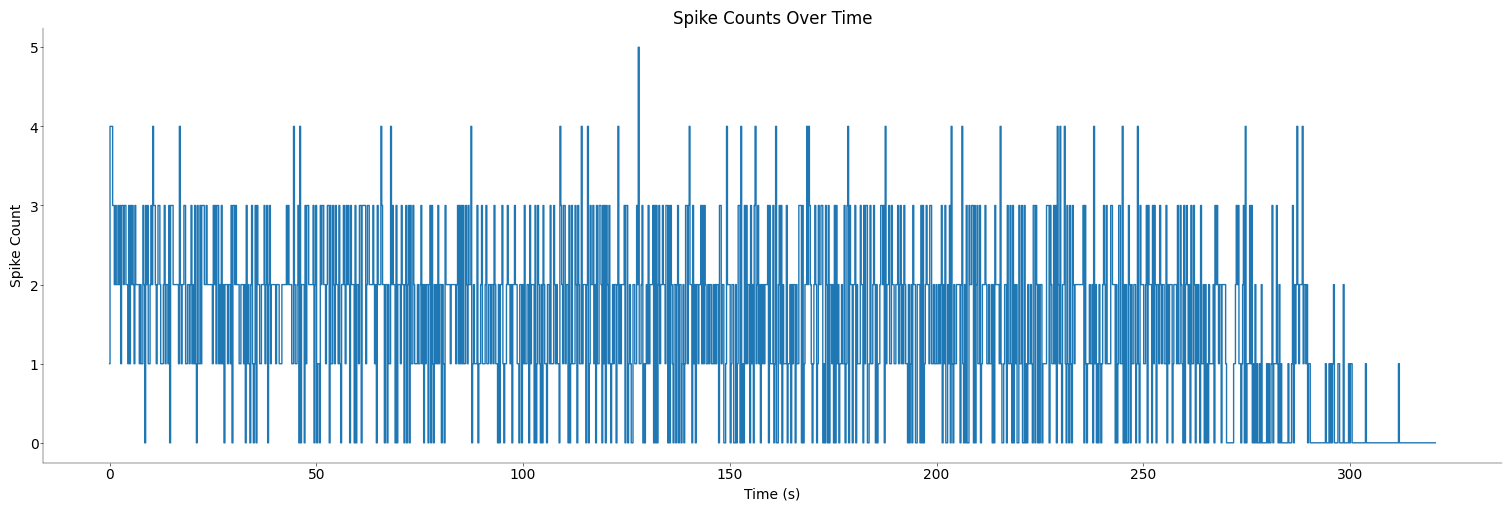

In [10]:
var = io.loadmat("../data/nds_cl_5_data.mat")

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten().copy()

print(var["DN_stim"].shape)
# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger) + 1]

# generate spike counts array at the resultion of the trigger
c = np.zeros(len(trigger))
for i in range(len(trigger)):
    # find the indices of the spikes that are within the trigger time
    ind = np.where((t >= trigger[i]) & (t < trigger[i] + 0.1))[0]
    c[i] = len(ind)


# Plot the spike counts over time
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(trigger, c, drawstyle="steps-mid")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Spike Count")
ax.set_title("Spike Counts Over Time")
plt.show()

Create vector of spike counts

In [11]:
# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

Fit receptive field for each frame separately

In [12]:
# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]

# fit for each delay

Plot the frames one by one and explain what you see.

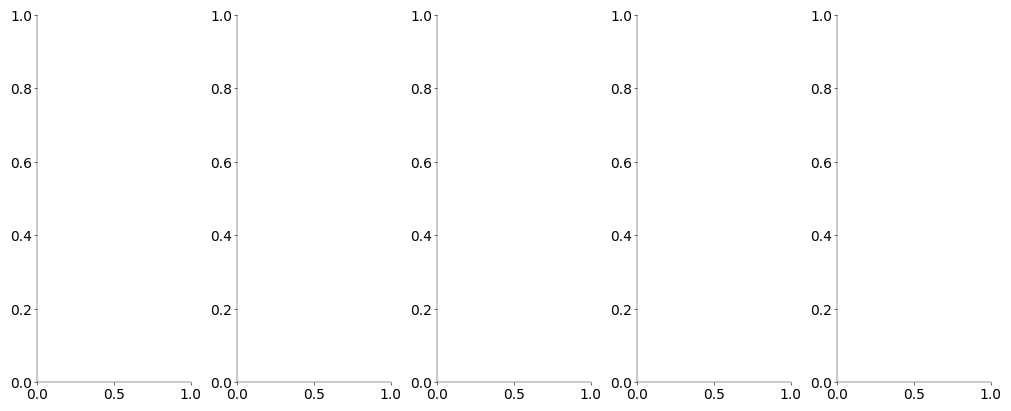

In [13]:
# --------------------------------------------
# Plot all 5 frames of the fitted RFs (1 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)

_Explanation (1 pt)_
...

# Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1.5 pts*

In [14]:
# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

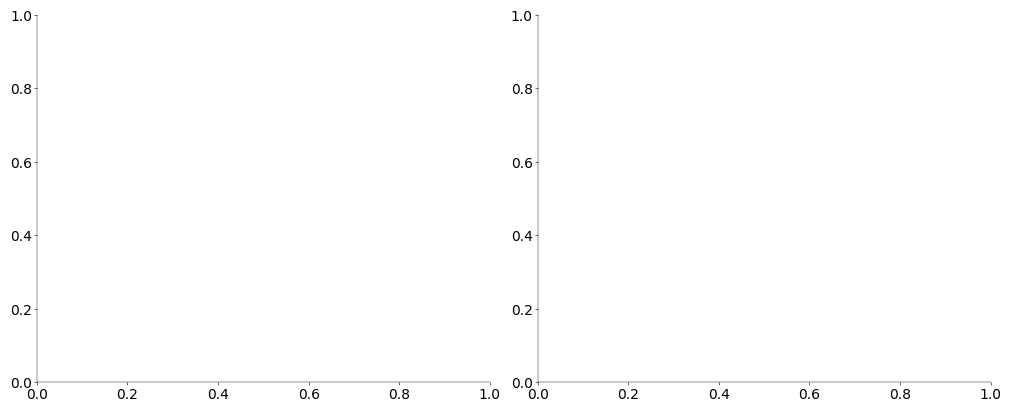

In [15]:
# -------------------------------------------------
# Plot the spatial and temporal components (1 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)
# add plot

# Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 3 pts*


In [40]:
from sklearn import linear_model
from pyglmnet import GLM

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklearn or pyglmnet for different values
# of alpha (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
alphas = np.logspace(-5, -2, 10)
# fit for each delay
print("Shape of alpha array", alphas.shape)

# 'c_binned' (binned spike counts, shape: num_frames) are defined from Task 2.
# For example, from previous cells:
var = io.loadmat("../data/nds_cl_5_data.mat")
s_data = var["DN_stim"].reshape((300, 1500))
trigger_times = var["DN_triggertimes"].flatten()
s = s_data[:, 1 : len(trigger_times) + 1]
spike_times = var["DN_spiketimes"].flatten()
c_binned = np.histogram(spike_times, bins=trigger_times)[0]

num_pixels = s.shape[0]
num_frames = s.shape[1]

# Initialize w_hat_glm to store the receptive fields

w_hat_glm = np.zeros((num_pixels, len(delta), len(alphas)))

# fit for each delay and each alpha
for alpha_idx, alpha_reg_strength in enumerate(alphas):
    print(f"Fitting for regularization strength (lambda) = {alpha_reg_strength:.4f}")
    for delay_idx, d_val in enumerate(delta):
        # Prepare data for the current delay d_val

        # Number of samples available for this delay
        n_samples_for_delay = num_frames - d_val

        if n_samples_for_delay <= 0:  # This check is fine
            print(
                f"  Skipping delay {d_val} for lambda {alpha_reg_strength:.4f} due to insufficient data points ({n_samples_for_delay})."
            )
            w_hat_glm[:, delay_idx, alpha_idx] = np.nan  # Or fill with zeros
            continue

        y_fit = c_binned[d_val : num_frames + 1]  # Spike counts for the current delay

        # X_fit needs to match the length of y_fit.
        X_fit = s[:, 0 : n_samples_for_delay - 1].T

        if (
            X_fit.shape[0] == 0
        ):  # Safeguard, should be caught by n_samples_for_delay check
            print(
                f"  Skipping delay {d_val} for lambda {alpha_reg_strength:.4f} as X_fit is empty."
            )
            w_hat_glm[:, delay_idx, alpha_idx] = np.nan
            continue

        print(f"  Fitting for delay {d_val}... (Using {X_fit.shape[0]} samples)")

        # Initialize and fit the GLM model (Lasso regression)
        model = GLM(
            distr="poisson",
            alpha=1.0,
            reg_lambda=alpha_reg_strength,
            solver="cdfast",
            max_iter=300,
            tol=1e-4,
            verbose=True,
        )  # Set to True for convergence messages from pyglmnet

        try:
            model.fit(X_fit, y_fit)
            # model.beta_ contains the fitted coefficients (weights) excluding intercept
            w_hat_glm[:, delay_idx, alpha_idx] = model.beta_
        except Exception as e:
            print(
                f"  Error fitting GLM for lambda {alpha_reg_strength:.2f}, delay {d_val}: {e}"
            )
            w_hat_glm[:, delay_idx, alpha_idx] = np.nan  # Store NaNs if fitting fails

print("\nFitting complete.")
# w_hat_glm now contains the estimated receptive fields.
# Shape of w_hat_glm: (num_pixels, len(delta), len(alphas))

Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Shape of alpha array (10,)
Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


c:\Users\Julius\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglmnet\pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 1... (Using 1487 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 2... (Using 1486 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 3... (Using 1485 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 4... (Using 1484 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 1... (Using 1487 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 2... (Using 1486 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 3... (Using 1485 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 4... (Using 1484 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 1... (Using 1487 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 2... (Using 1486 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 3... (Using 1485 samples)


Lambda: 0.0000
INFO:pyglmnet:Lambda: 0.0000


  Fitting for delay 4... (Using 1484 samples)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


  Fitting for delay 1... (Using 1487 samples)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


  Fitting for delay 2... (Using 1486 samples)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


  Fitting for delay 3... (Using 1485 samples)


Lambda: 0.0001
INFO:pyglmnet:Lambda: 0.0001


  Fitting for delay 4... (Using 1484 samples)


Lambda: 0.0002
INFO:pyglmnet:Lambda: 0.0002


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


Lambda: 0.0002
INFO:pyglmnet:Lambda: 0.0002


  Fitting for delay 1... (Using 1487 samples)


Lambda: 0.0002
INFO:pyglmnet:Lambda: 0.0002


  Fitting for delay 2... (Using 1486 samples)


Lambda: 0.0002
INFO:pyglmnet:Lambda: 0.0002


  Fitting for delay 3... (Using 1485 samples)


Lambda: 0.0002
INFO:pyglmnet:Lambda: 0.0002


  Fitting for delay 4... (Using 1484 samples)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


  Fitting for delay 1... (Using 1487 samples)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


  Fitting for delay 2... (Using 1486 samples)


Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


  Fitting for delay 3... (Using 1485 samples)


	Parameter update tolerance. Converged in 281 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 281 iterations
Lambda: 0.0005
INFO:pyglmnet:Lambda: 0.0005


  Fitting for delay 4... (Using 1484 samples)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


  Fitting for delay 1... (Using 1487 samples)


	Parameter update tolerance. Converged in 269 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 269 iterations
Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


  Fitting for delay 2... (Using 1486 samples)


	Parameter update tolerance. Converged in 249 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 249 iterations
Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


  Fitting for delay 3... (Using 1485 samples)


	Parameter update tolerance. Converged in 276 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 276 iterations
Lambda: 0.0010
INFO:pyglmnet:Lambda: 0.0010


  Fitting for delay 4... (Using 1484 samples)


	Parameter update tolerance. Converged in 293 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 293 iterations
Lambda: 0.0022
INFO:pyglmnet:Lambda: 0.0022


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


	Parameter update tolerance. Converged in 210 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 210 iterations
Lambda: 0.0022
INFO:pyglmnet:Lambda: 0.0022


  Fitting for delay 1... (Using 1487 samples)


	Parameter update tolerance. Converged in 229 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 229 iterations
Lambda: 0.0022
INFO:pyglmnet:Lambda: 0.0022


  Fitting for delay 2... (Using 1486 samples)


	Parameter update tolerance. Converged in 240 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 240 iterations
Lambda: 0.0022
INFO:pyglmnet:Lambda: 0.0022


  Fitting for delay 3... (Using 1485 samples)


	Parameter update tolerance. Converged in 218 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 218 iterations
Lambda: 0.0022
INFO:pyglmnet:Lambda: 0.0022


  Fitting for delay 4... (Using 1484 samples)


	Parameter update tolerance. Converged in 195 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 195 iterations
Lambda: 0.0046
INFO:pyglmnet:Lambda: 0.0046


Fitting for regularization strength (lambda) = 0.00
  Fitting for delay 0... (Using 1488 samples)


	Parameter update tolerance. Converged in 165 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 165 iterations
Lambda: 0.0046
INFO:pyglmnet:Lambda: 0.0046


  Fitting for delay 1... (Using 1487 samples)


	Parameter update tolerance. Converged in 146 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 146 iterations
Lambda: 0.0046
INFO:pyglmnet:Lambda: 0.0046


  Fitting for delay 2... (Using 1486 samples)


	Parameter update tolerance. Converged in 121 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 121 iterations
Lambda: 0.0046
INFO:pyglmnet:Lambda: 0.0046


  Fitting for delay 3... (Using 1485 samples)


	Parameter update tolerance. Converged in 169 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 169 iterations
Lambda: 0.0046
INFO:pyglmnet:Lambda: 0.0046


  Fitting for delay 4... (Using 1484 samples)


	Parameter update tolerance. Converged in 137 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 137 iterations
Lambda: 0.0100
INFO:pyglmnet:Lambda: 0.0100


Fitting for regularization strength (lambda) = 0.01
  Fitting for delay 0... (Using 1488 samples)


	Parameter update tolerance. Converged in 87 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 87 iterations
Lambda: 0.0100
INFO:pyglmnet:Lambda: 0.0100


  Fitting for delay 1... (Using 1487 samples)


	Parameter update tolerance. Converged in 86 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 86 iterations
Lambda: 0.0100
INFO:pyglmnet:Lambda: 0.0100


  Fitting for delay 2... (Using 1486 samples)


	Parameter update tolerance. Converged in 70 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 70 iterations
Lambda: 0.0100
INFO:pyglmnet:Lambda: 0.0100


  Fitting for delay 3... (Using 1485 samples)


	Parameter update tolerance. Converged in 72 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 72 iterations
Lambda: 0.0100
INFO:pyglmnet:Lambda: 0.0100


  Fitting for delay 4... (Using 1484 samples)


	Parameter update tolerance. Converged in 88 iterations
INFO:pyglmnet:	Parameter update tolerance. Converged in 88 iterations



Fitting complete.


Number of non-NaN and non-zero values in w_hat_glm: 15000


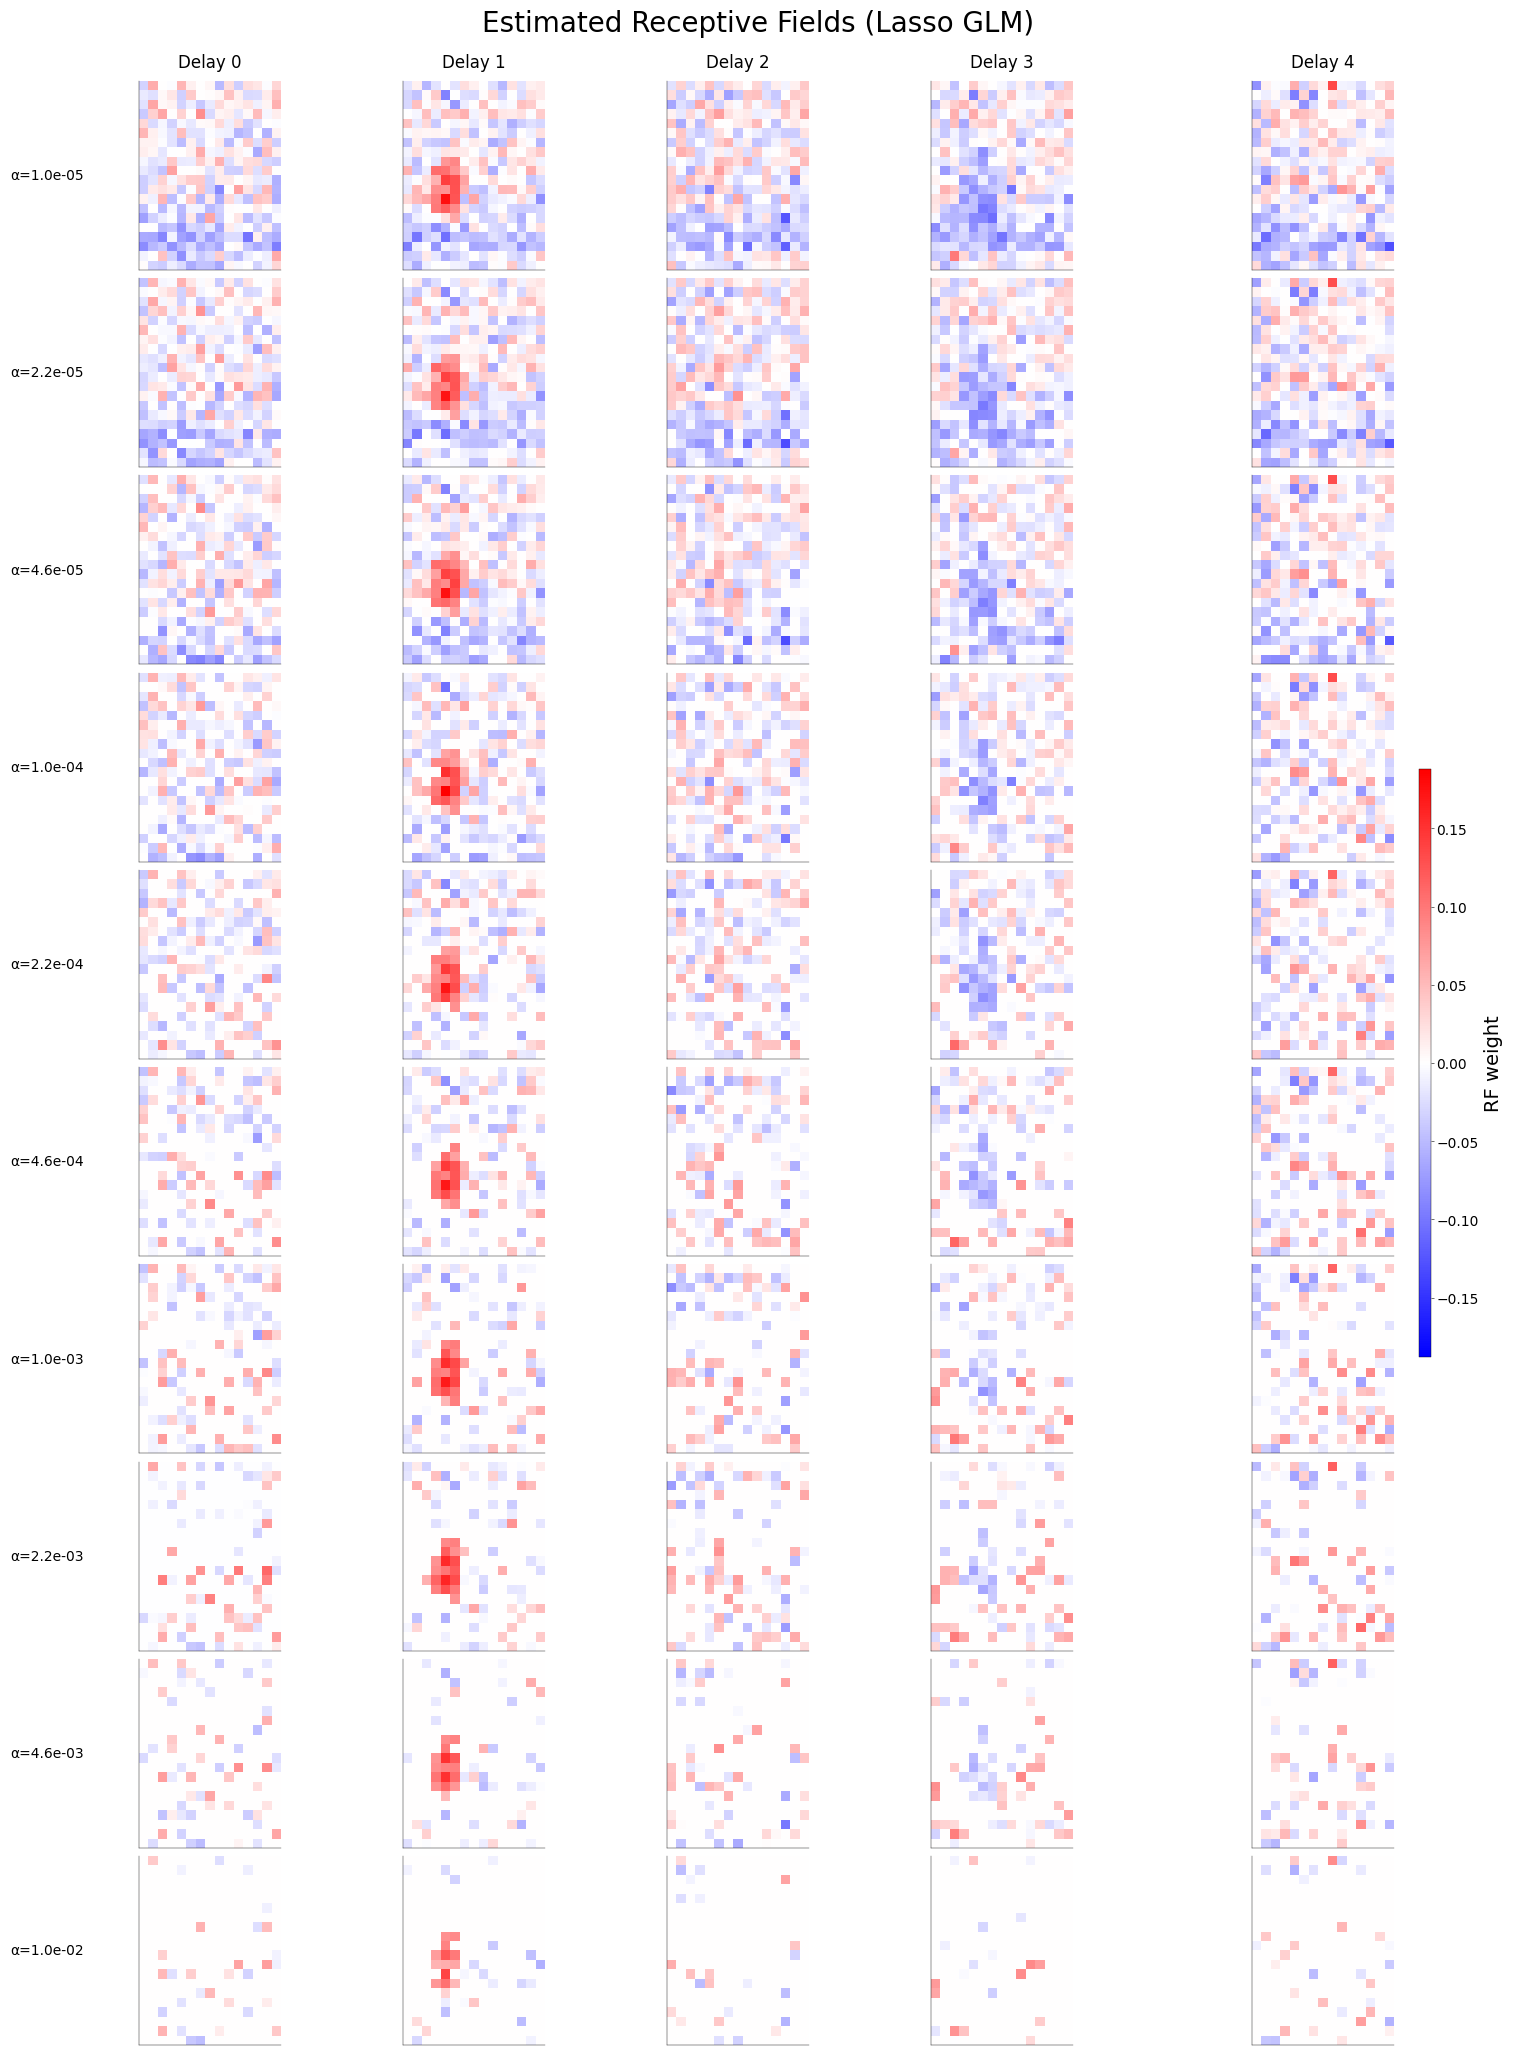

In [47]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

# show the number of values that are neither zero nor NaN
print(
    f"Number of non-NaN and non-zero values in w_hat_glm: {np.count_nonzero(~np.isnan(w_hat_glm))}"
)

fig, ax = plt.subplots(
    len(alphas), len(delta), sharex=True, sharey=True, figsize=(15, 20)
)

# Correctly calculate vmin and vmax for consistent and symmetric color scaling across all subplots
if np.all(np.isnan(w_hat_glm)):
    # Handle case where all w_hat_glm values are NaN (e.g., if fitting failed everywhere)
    vmin_val = -1.0
    vmax_val = 1.0
else:
    abs_max_val = np.nanmax(np.abs(w_hat_glm))  # Max absolute value, ignoring NaNs
    if abs_max_val == 0 or np.isnan(
        abs_max_val
    ):  # Handles all zeros or if somehow still NaN
        vmin_val = -1.0  # Default if data is all zero or problematic
        vmax_val = 1.0
    else:
        vmin_val = -abs_max_val
        vmax_val = abs_max_val

for alpha_idx, alpha_reg_strength in enumerate(alphas):
    for delay_idx, d_val in enumerate(delta):
        # Plot the estimated receptive field
        rf_to_plot = w_hat_glm[:, delay_idx, alpha_idx].reshape(20, 15)
        if np.all(np.isnan(rf_to_plot)):
            # Handle cases where a specific RF is all NaN (e.g., skipped during fitting)
            # You could plot a placeholder or leave it blank
            ax[alpha_idx, delay_idx].text(
                0.5,
                0.5,
                "NaN",
                ha="center",
                va="center",
                transform=ax[alpha_idx, delay_idx].transAxes,
            )
            im = None  # No image object to use for colorbar later if this is the last one
        else:
            im = ax[alpha_idx, delay_idx].imshow(
                rf_to_plot,
                vmin=vmin_val,  # Use vmin for lower color scale limit
                vmax=vmax_val,  # Use vmax for upper color scale limit
                cmap="bwr",
                interpolation="nearest",  # Often better for pixelated data
            )

        if alpha_idx == 0:  # Titles for the top row
            ax[alpha_idx, delay_idx].set_title(f"Delay {d_val}", y=1.05)

        if delay_idx == 0:  # Y-labels for the first column
            ax[alpha_idx, delay_idx].set_ylabel(
                f"α={alpha_reg_strength:.1e}",
                rotation=0,
                ha="right",
                va="center",
                labelpad=40,
            )
        ax[alpha_idx, delay_idx].set_xticks([])
        ax[alpha_idx, delay_idx].set_yticks([])

# Add colorbar
# Make sure 'im' is from a successfully plotted image
if im is not None:  # Check if 'im' was assigned
    cbar = fig.colorbar(
        im, ax=ax[:, -1].ravel().tolist(), fraction=0.046, pad=0.1, aspect=50
    )  # Adjust aspect for colorbar
    cbar.set_label("RF weight", fontsize=14)
else:
    print("Warning: No valid image was plotted to create a colorbar from.")

fig.suptitle("Estimated Receptive Fields (Lasso GLM)", fontsize=20, y=1.02)
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect if using suptitle
plt.show()

The lasso-penalization effectively increases the cost of large coefficients in the receptive field and thus leads to a more robust estimate. The regularization parameter $\alpha$ controls the strength of this penalty. 

When you increase $\alpha$, the coefficients in the receptive field are shrunk more towards zero (as seen in the bottom rows), leading to a sparser solution. If you decrease $\alpha$, the coefficients are less penalized, and the receptive field can take larger values, potentially leading to overfitting.

## Bonus Task (Optional): Spike Triggered Average

Instead of the Maximum Likelihood implementation above, estimate the receptive field using the spike triggered average.
Use it to increase the temporal resolution of your receptive field estimate.
Perform the SVD analysis for your STA-based receptive field and plot the spatial and temporal kernel as in Task 3.

**Questions:**
1. Explain how / why you chose a specific time delta.
2. Reconsider what you know about STA. Is it suitable to use STA for this data? Why/why not? What are the (dis-)advantages of using the MLE based method from above?

_Grading: 1 BONUS Point._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

Computing STA for T = 30 frames...
Stimulus shape: (300, 1489)
Spike counts shape: (1489,)
Total spikes: 5493.0
Stimulus mean shape: (300, 1)
Total contributing spikes: 5328.0
STA shape: (300, 30)
SVD shapes: U=(300, 30), S=(30,), Vt=(30, 30)


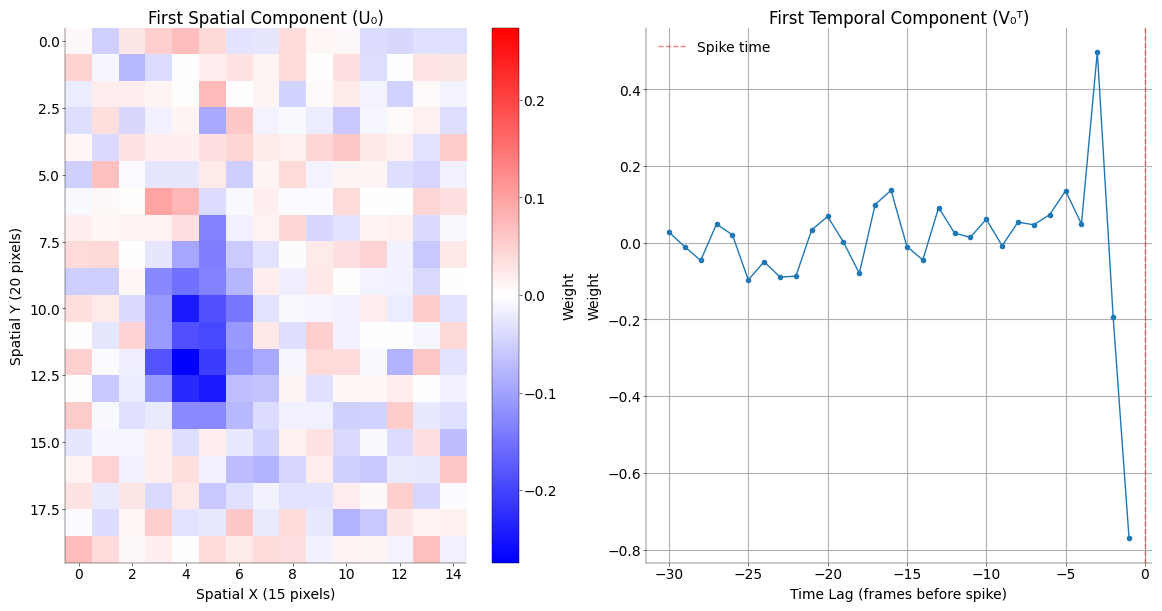


Singular values (first 5): [0.16674041 0.15200556 0.1299146  0.12124906 0.11830279]
Explained variance by first component: 9.6%


In [46]:
# compute the spike triggered average

# Load data from Task 2
var = io.loadmat("../data/nds_cl_5_data.mat")
s_data = var["DN_stim"].reshape((300, 1500))
trigger_times = var["DN_triggertimes"].flatten()
spike_times = var["DN_spiketimes"].flatten()

# Use the stimulus from earlier
stim_data = s_data[:, 1 : len(trigger_times) + 1]

# Create proper spike count bins
c_binned = np.zeros(len(trigger_times))
for i in range(len(trigger_times)):
    # Count spikes in each stimulus frame interval
    if i < len(trigger_times) - 1:
        spike_mask = (spike_times >= trigger_times[i]) & (
            spike_times < trigger_times[i + 1]
        )
    else:
        spike_mask = (spike_times >= trigger_times[i]) & (
            spike_times < trigger_times[i] + 0.1
        )
    c_binned[i] = np.sum(spike_mask)

num_pixels = stim_data.shape[0]
num_frames = stim_data.shape[1]

# Choose temporal window length for STA
T_window = 30  # frames before spike time

print(f"Computing STA for T = {T_window} frames...")
print(f"Stimulus shape: {stim_data.shape}")
print(f"Spike counts shape: {c_binned.shape}")
print(f"Total spikes: {np.sum(c_binned)}")

# Compute overall stimulus mean (crucial for proper STA!)
stim_mean = np.mean(stim_data, axis=1, keepdims=True)  # Shape: (num_pixels, 1)
print(f"Stimulus mean shape: {stim_mean.shape}")

# Initialize STA accumulator
sta_sum = np.zeros((num_pixels, T_window))
total_spikes = 0

# Compute STA
for t_spike in range(T_window, num_frames):
    if c_binned[t_spike] > 0:  # Only consider time bins with spikes
        # Get stimulus window: T_window frames ending at t_spike
        start_idx = t_spike - T_window
        end_idx = t_spike

        stim_window = stim_data[:, start_idx:end_idx]  # Shape: (num_pixels, T_window)

        # Subtract mean from stimulus window
        stim_window_centered = stim_window - stim_mean

        # Add to STA, weighted by number of spikes
        sta_sum += stim_window_centered * c_binned[t_spike]
        total_spikes += c_binned[t_spike]

# Normalize by total number of spikes
if total_spikes > 0:
    sta = sta_sum / total_spikes
else:
    print("No spikes found!")
    sta = sta_sum

print(f"Total contributing spikes: {total_spikes}")
print(f"STA shape: {sta.shape}")

# Important: Subtract mean from STA before SVD (as mentioned in Task 3)
sta_mean_subtracted = sta - np.mean(sta, axis=1, keepdims=True)

# Perform SVD on the mean-subtracted STA
U, S, Vt = np.linalg.svd(sta_mean_subtracted, full_matrices=False)
print(f"SVD shapes: U={U.shape}, S={S.shape}, Vt={Vt.shape}")

# Plot results as in Task 3
fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(12, 6), constrained_layout=True
)

# Plot the first spatial component from SVD (reshaped to 20x15)
first_spatial_component = U[:, 0].reshape(20, 15)
spatial_vmax = np.max(np.abs(first_spatial_component))
im = ax["Spatial"].imshow(
    first_spatial_component,
    cmap="bwr",
    vmin=-spatial_vmax,
    vmax=spatial_vmax,
    interpolation="nearest",
)
ax["Spatial"].set_title("First Spatial Component (U₀)")
ax["Spatial"].set_xlabel("Spatial X (15 pixels)")
ax["Spatial"].set_ylabel("Spatial Y (20 pixels)")
fig.colorbar(im, ax=ax["Spatial"], label="Weight")

# Plot the first temporal component
first_temporal_component = Vt[0, :]
# Time axis: negative values are frames before spike (0 is spike time)
time_lags = np.arange(-T_window, 0)
ax["Temporal"].plot(time_lags, first_temporal_component, "o-", markersize=3)
ax["Temporal"].set_title("First Temporal Component (V₀ᵀ)")
ax["Temporal"].set_xlabel("Time Lag (frames before spike)")
ax["Temporal"].set_ylabel("Weight")
ax["Temporal"].grid(True)
ax["Temporal"].axvline(x=0, color="r", linestyle="--", alpha=0.5, label="Spike time")
ax["Temporal"].legend()

plt.show()

# Print diagnostics
print(f"\nSingular values (first 5): {S[:5]}")
print(f"Explained variance by first component: {S[0]**2 / np.sum(S**2) * 100:.1f}%")

### Answers to Bonus Questions

**1. Time delta choice:**
We chose a time lag of 30 frames for the implementation of the STA. This is rough compromise between capturing as much temporal information as possible while still having a discernable receptive field in the spatial first spatial component (+ less computational cost). When we set the τ > 40 Frames the spatial component would no longer the receptive field, but just a noisy 20 x 15 pixel image.

**2. Suitability of STA for this data:**

**Advantages of STA:**
- **Simple and robust**: No optimization required, less prone to local minima
- **Model-free**: Makes no assumptions about the nonlinearity
- **Fast computation**: Direct calculation from spike-triggered stimuli
- **Interpretable**: Directly shows average stimulus preceding spikes

**Disadvantages of STA:**
- **Assumes white noise stimulus**: Requires uncorrelated stimulus for unbiased estimates
- **Linear assumption**: Only captures linear components of the receptive field
- **Low spike count sensitivity**: Requires many spikes for stable estimates
- **No nonlinearity modeling**: Cannot account for the exponential nonlinearity in LNP models

**Advantages of MLE method:**
- **Accounts for nonlinearity**: Explicitly models the exponential function in LNP
- **Optimal under model assumptions**: Maximum likelihood is asymptotically efficient
- **Better with few spikes**: Can work with lower spike counts due to model constraints
- **Principled uncertainty quantification**: Provides confidence intervals

**Disadvantages of MLE method:**
- **Model dependent**: Assumes specific LNP structure
- **Optimization complexity**: Requires careful initialization and can get stuck in local minima
- **Computational cost**: More expensive, especially with regularization
- **Sensitive to model misspecification**: Poor performance if model assumptions are violated

**Conclusion**: For this binary white noise stimulus data, STA is quite suitable as it meets the white noise assumption. However, the MLE approach should theoretically perform better due to its explicit modeling of the Poisson spiking and exponential nonlinearity.